<a href="https://colab.research.google.com/github/lphuong304/CS114.L21/blob/main/COLAB_ASSIGNMENTS/COLAB_ASSIGNMENT_17_05/Solution02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><b>BÀI TẬP COLAB SỐ 03 - 17/05/2021</b></h1>
<h1 align="center"><b>PREDICT FINAL SCORE OF IT001</b></h1>

###LỚP: CS114.L21
###NHÓM:
1. Nguyễn Ngọc Lan Phương - *19520227*
2. Hoàng Anh Tú - *19522450*
3. Nguyễn Quốc Huy - *19521623*

Nguồn tham khảo:




Link data:
* Data wecode: [link](https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/wecode.csv)
* Data score: [link](https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/wecode.csv)


References:
1. [Import Packages and Discovery and Visualize Data](#part1)
2. [Pre-processing Data and Show the Correlation of the features](#process)
3. [Traning Model and Testing](#model)

#1. Import Packages Import Package and Discovery and Visualize Data
<a name = 'part1'></a>

## 1.1 Import Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import  accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## 1.2 Data Discovery

In [ ]:
data_score = pd.read_csv('https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/score_training.csv')
data = pd.read_csv('https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/wecode.csv')

In [ ]:
data.head(5)

,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100,solution-0,2,2020-10-30 10:58:11,2020-10-30 10:58:19
1,5,0,4,4,1,SCORE,10000,100,solution-1,2,2020-10-30 11:07:09,2020-10-30 11:07:17
2,6,0,5,4,0,Compilation Error,0,100,solution-2,2,2020-10-30 11:08:01,2020-10-30 11:23:36
3,7,0,5,4,0,Compilation Error,0,100,solution-3,2,2020-10-30 11:11:41,2020-10-30 11:11:42
4,8,0,5,4,0,Compilation Error,0,100,solution-4,2,2020-10-30 11:15:06,2020-10-30 11:15:07


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             264606 non-null  int64 
 1   assignment_id  264606 non-null  int64 
 2   problem_id     264606 non-null  int64 
 3   user_id        264606 non-null  int64 
 4   is_final       264606 non-null  int64 
 5   status         264605 non-null  object
 6   pre_score      264606 non-null  int64 
 7   coefficient    264606 non-null  object
 8   file_name      264606 non-null  object
 9   language_id    264606 non-null  int64 
 10  created_at     264606 non-null  object
 11  updated_at     264606 non-null  object
dtypes: int64(7), object(5)
memory usage: 24.2+ MB


In [ ]:
#tries - tổng số lần nộp của mỗi user_id, tính luôn đã submit và chưa submit, cả những lần nộp bài full điểm cà chưa full điểm
raw = pd.DataFrame({'tries' : data['user_id'].value_counts()})
raw = raw.sort_index()

In [ ]:
# solved - số problem đã giải được của mỗi user_id => is_final = 1 và pre-score = 10000
user_isfinal_score = data[['user_id', 'is_final', 'pre_score']]

solvedData = user_isfinal_score[(user_isfinal_score['is_final'] > 0) & (user_isfinal_score['pre_score'] == 10000)].groupby('user_id').sum()

solvedData.drop('pre_score', axis=1, inplace=True)
solvedData.rename(columns={'is_final':'solved'}, inplace=True)

raw = pd.concat([raw, solvedData], axis=1)
raw = raw.fillna(0.0)


In [ ]:
#num_problemSumbited - tổng số problem đã sumbit cuối cùng của mỗi user_id trên tổng số lần thử, những bài submit có thể full điểm và không full điểm

# array of user_id
list_userID = data['user_id'].tolist()
listStr_userID = data['user_id'].astype(str).tolist()

# array of assignment_id
list_assignmentID = data['assignment_id'].astype(str).tolist()

# array of problem_id
list_problemID = data['problem_id'].astype(str).tolist()
list_problemID
# connect user-assignment-problem
for i in range(len(list_assignmentID)):
  list_assignmentID[i] = listStr_userID[i] + ' ' + list_assignmentID[i] + ' ' + list_problemID[i]

list_assignmentID
dictData = {'user_id': list_userID,
        'num_problemSumbited': list_assignmentID}

num_problemSumbitedDF = pd.DataFrame(dictData).set_index('user_id')
num_problemSumbitedDF
num_problemSumbitedDF = num_problemSumbitedDF.groupby('user_id').nunique()

raw = pd.concat([raw, num_problemSumbitedDF], axis=1)


In [ ]:
#tổng điểm các bài được cuối cùng của mỗi user
user_isfinal_score = data[['user_id', 'is_final', 'pre_score']]

trueScore = user_isfinal_score[user_isfinal_score['is_final'] > 0].groupby('user_id').sum()
trueScore = trueScore.drop('is_final', axis=1)
trueScore.rename(columns={'pre_score':'total_FinalScore'}, inplace=True)

raw = pd.concat([raw, trueScore], axis=1)
raw

,tries,solved,num_problemSumbited,total_FinalScore
1,2,1.0,2,10000.0
4,54,37.0,41,370000.0
5,6,3.0,5,30000.0
6,130,85.0,89,850000.0
7,5,0.0,2,9209.0
...,...,...,...,...
1860,76,28.0,48,329665.0
1862,12,4.0,6,40000.0
1864,187,28.0,63,439741.0
1865,99,10.0,17,116428.0


In [ ]:
data_score['CK'] = pd.to_numeric(data_score['CK'], errors='coerce')
raw_ck = data_score['CK']

## 1.3 Data Visualization

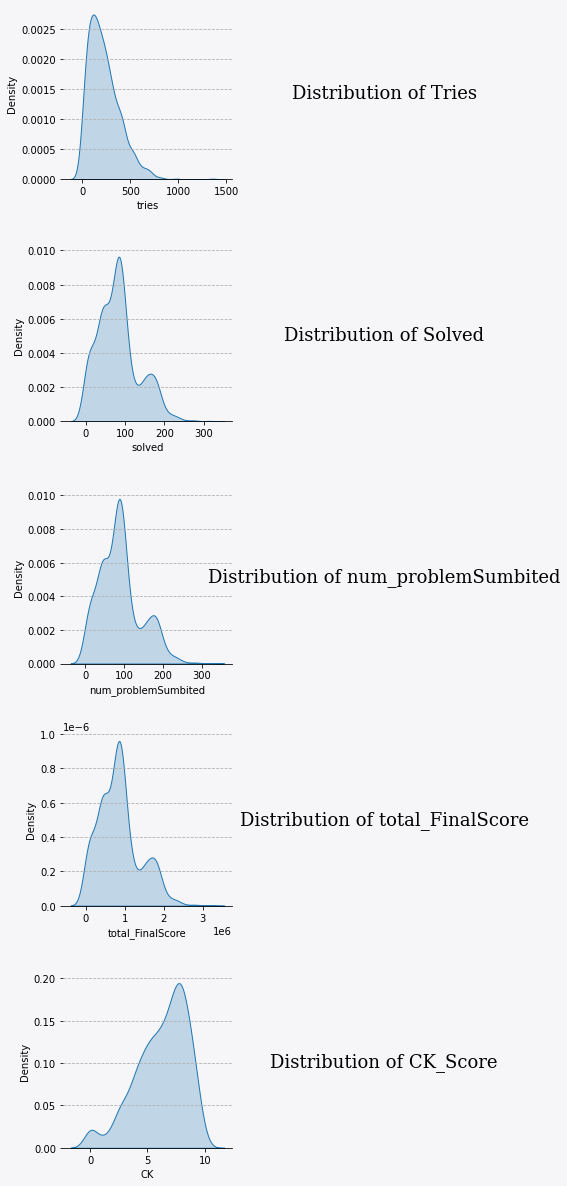

In [ ]:
fig= plt.figure(figsize = (20,21))
gs = fig.add_gridspec(5,5)
gs.update(wspace=0.4, hspace=0.4)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,0])
ax9 = fig.add_subplot(gs[4,1])
axes=[ax0,ax1,ax2,ax3,ax4,ax5, ax6, ax7, ax8, ax9]
background_color = '#f6f5f7'

for i in axes:
    i.set_facecolor(background_color)
fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax = ax0, data=raw['tries'],shade=True,palette='rocket', label = 'tries') # Distributions
ax0.grid(linestyle='--', axis='y')
ax1.text(0.5,0.5,'Distribution of Tries',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax= ax2, data=raw['solved'],shade=True,palette='rocket', label = 'solved') # Distributions
ax2.grid(linestyle='--', axis='y')
ax3.text(0.5,0.5,'Distribution of Solved',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax = ax4, data=raw['num_problemSumbited'],shade=True,palette='rocket', label = 'num_problemSumbited') # Distributions
ax4.grid(linestyle='--', axis='y')
ax5.text(0.5,0.5,'Distribution of num_problemSumbited',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax= ax6, data= raw['total_FinalScore'],shade=True,palette='rocket', label = 'total_FinalScore') # Distributions
ax6.grid(linestyle='--', axis='y')
ax7.text(0.5,0.5,'Distribution of total_FinalScore',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax= ax8, data = raw_ck,shade=True,palette='rocket', label = 'CK_Score') # Distributions
ax8.grid(linestyle='--', axis='y')
ax9.text(0.5,0.5,'Distribution of CK_Score',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')



axes1=[ax1,ax3,ax5,ax7,ax9]
for i in axes1:
    i.spines["bottom"].set_visible(False)
    i.spines["left"].set_visible(False)
    i.set_xlabel("")
    i.set_ylabel("")
    i.set_xticklabels([])
    i.set_yticklabels([])
    i.tick_params(left=False, bottom=False)
# removing spines of figures
for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)
    ax6.spines[i].set_visible(False)
    ax7.spines[i].set_visible(False)
    ax8.spines[i].set_visible(False)
    ax9.spines[i].set_visible(False)

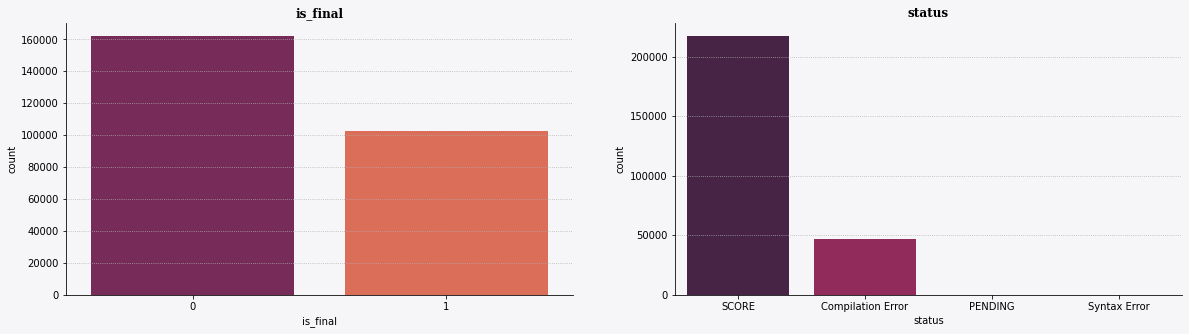

In [ ]:
fig=plt.figure(figsize=(20,23))
background_color = '#f6f5f7'
fig.patch.set_facecolor(background_color) 
data_categorical = pd.concat([data['is_final'], data['status']], axis=1)
for indx,val in enumerate(data_categorical.columns):
    ax=plt.subplot(4,2,indx+1)
    ax.set_facecolor(background_color)
    ax.set_title(val,fontweight='bold',fontfamily='serif')
    for i in ['top','right']:
        ax.spines[i].set_visible(False)
    ax.grid(linestyle=':',axis='y')
    sns.countplot(data_categorical[val],palette='rocket')

In [ ]:
# set type of element
raw = raw.astype(float)
raw

,tries,solved,num_problemSumbited,total_FinalScore
1,2.0,1.0,2.0,10000.0
4,54.0,37.0,41.0,370000.0
5,6.0,3.0,5.0,30000.0
6,130.0,85.0,89.0,850000.0
7,5.0,0.0,2.0,9209.0
...,...,...,...,...
1860,76.0,28.0,48.0,329665.0
1862,12.0,4.0,6.0,40000.0
1864,187.0,28.0,63.0,439741.0
1865,99.0,10.0,17.0,116428.0


## 1.4 Create New Dataframe

In [ ]:
#@title
#cell này Phưn hông có chạy
index = raw.index.tolist()
list_tries = raw['tries'].tolist()
list_solved = raw['solved'].tolist()
list_numProblemSumbited = raw['num_problemSumbited'].values.tolist()

list_numProblemSumbited,list_solved
#Tổng pre_score của các submssion có is_final = 1
list_totalFinalScore = raw['total_FinalScore'].tolist()

# Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số problem có submit = solved/submiited
solved_per_submitted = []
for i in range(len(index)):
  solved_per_submitted.append(list_solved[i] / list_numProblemSumbited[i])

#Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số lần thử submit = solved/tries
solved_tries = []
for i in range(len(index)):
  solved_tries.append(list_solved[i] / list_tries[i])
# # Tổng số problem đã sumbit / Tổng số submissions ?? #xàm te :)) nó ra 1 mà :))
# # probSubmited_totalSubmit = []
# # for i in range(len(index)):
# #   probSubmited_totalSubmit.append(list_numProblemSumbited[i] / 264606)

In [ ]:
dict_newData = {'index': index,
                    'tries': list_tries,
                    'solved': list_solved,
                    'submited': list_numProblemSumbited,
                    'solved/tries': solved_tries,
                    'solved/submited': solved_per_submitted,
                    'finalScore': list_totalFinalScore
}

newDF = pd.DataFrame(dict_newData).set_index('index')
newDF

,tries,solved,submited,solved/tries,solved/submited,finalScore
index,,,,,,
1,2.0,1.0,2.0,0.500000,0.500000,10000.0
4,54.0,37.0,41.0,0.685185,0.902439,370000.0
5,6.0,3.0,5.0,0.500000,0.600000,30000.0
6,130.0,85.0,89.0,0.653846,0.955056,850000.0
7,5.0,0.0,2.0,0.000000,0.000000,9209.0
...,...,...,...,...,...,...
1860,76.0,28.0,48.0,0.368421,0.583333,329665.0
1862,12.0,4.0,6.0,0.333333,0.666667,40000.0
1864,187.0,28.0,63.0,0.149733,0.444444,439741.0


In [ ]:
newDF.dropna()
newDF

,tries,solved,submited,solved/tries,solved/submited,finalScore
index,,,,,,
1,2.0,1.0,2.0,0.500000,0.500000,10000.0
4,54.0,37.0,41.0,0.685185,0.902439,370000.0
5,6.0,3.0,5.0,0.500000,0.600000,30000.0
6,130.0,85.0,89.0,0.653846,0.955056,850000.0
7,5.0,0.0,2.0,0.000000,0.000000,9209.0
...,...,...,...,...,...,...
1860,76.0,28.0,48.0,0.368421,0.583333,329665.0
1862,12.0,4.0,6.0,0.333333,0.666667,40000.0
1864,187.0,28.0,63.0,0.149733,0.444444,439741.0


In [ ]:
score_CK = data_score[['id', 'CK']]
score_CK.set_index('id', inplace=True)
new_data = pd.concat([newDF, score_CK], axis=1)
new_data.head(10).T

,1,4,5,6,7,11,14,15,20,22
tries,2.0,54.000000,6.0,130.000000,5.0,50.000000,22.000000,101.000000,13.000000,NaN
solved,1.0,37.000000,3.0,85.000000,0.0,9.000000,6.000000,45.000000,12.000000,NaN
submited,2.0,41.000000,5.0,89.000000,2.0,19.000000,7.000000,52.000000,12.000000,NaN
solved/tries,0.5,0.685185,0.5,0.653846,0.0,0.180000,0.272727,0.445545,0.923077,NaN
solved/submited,0.5,0.902439,0.6,0.955056,0.0,0.473684,0.857143,0.865385,1.000000,NaN
finalScore,10000.0,370000.000000,30000.0,850000.000000,9209.0,100316.000000,68000.000000,458666.000000,120000.000000,NaN
CK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5


#2. Pre-processing Data and Show the Correlation of the features
<a name = 'process'></a>

## 2.1 Handling Missing Values in Data

In [ ]:
#find NaN values and replace it with 0
def count_missing_values(data):
  num_of_miss_data = data.isnull().sum()
  missing_data = pd.concat([num_of_miss_data], axis=1, keys = ['Number of missing value'])
  return missing_data
count_missing_values(new_data)

,Number of missing value
tries,122
solved,122
submited,122
solved/tries,122
solved/submited,122
finalScore,124
CK,361


In [ ]:
#fill missing value of column 'tries'
new_data['tries'] = new_data['tries'].interpolate(method = 'pad', limit = 3)
new_data['tries'] = new_data['tries'].fillna(int(np.mean(new_data['tries'])))

In [ ]:
#fill missing value of column 'solved'
new_data['solved'] = new_data['solved'].interpolate(method = 'pad', limit = 3)
new_data['solved'] = new_data['solved'].fillna(int(np.mean(new_data['solved'])))

In [ ]:
#fill missing value of column 'summited'
new_data['submited'] = new_data['submited'].interpolate(method = 'pad', limit = 3)
new_data['submited'] = new_data['submited'].fillna(int(np.mean(new_data['submited'])))

In [ ]:
new_data['solved/tries'] = new_data['solved'] / new_data['tries'] 
new_data['solved/submited'] = new_data['solved'] / new_data['submited'] 

In [ ]:
new_data['finalScore'] = new_data['finalScore'].interpolate(method = 'pad', limit = 3)
new_data['finalScore'] = new_data['finalScore'].fillna(int(np.mean(new_data['finalScore'])))

In [ ]:
data_to_predict = new_data[new_data.isna().any(axis=1)]
data_to_predict = data_to_predict[data_to_predict['solved/tries'] <= 1]
data_to_predict = data_to_predict[data_to_predict['solved/submited'] <= 1]
data_to_predict

,tries,solved,submited,solved/tries,solved/submited,finalScore,CK
1,2.0,1.0,2.0,0.500000,0.500000,10000.0,NaN
4,54.0,37.0,41.0,0.685185,0.902439,370000.0,NaN
5,6.0,3.0,5.0,0.500000,0.600000,30000.0,NaN
6,130.0,85.0,89.0,0.653846,0.955056,850000.0,NaN
7,5.0,0.0,2.0,0.000000,0.000000,9209.0,NaN
...,...,...,...,...,...,...,...
1852,20.0,1.0,1.0,0.050000,1.000000,10000.0,NaN
1855,134.0,63.0,67.0,0.470149,0.940299,649000.0,NaN
1860,76.0,28.0,48.0,0.368421,0.583333,329665.0,NaN
1864,187.0,28.0,63.0,0.149733,0.444444,439741.0,NaN


In [ ]:
id_predict = data_to_predict.index.to_numpy()

In [ ]:
data_to_train = new_data.dropna()
data_to_train = data_to_train[data_to_train['solved/tries'] <= 1]
data_to_train = data_to_train[data_to_train['solved/submited'] <= 1]

In [ ]:
data_to_train.describe()

,tries,solved,submited,solved/tries,solved/submited,finalScore,CK
count,920.000000,920.000000,920.000000,920.000000,920.000000,9.200000e+02,920.000000
mean,240.764130,86.750000,93.559783,0.385580,0.884055,8.952187e+05,6.192935
std,167.205639,52.366214,53.692214,0.147076,0.164510,5.338194e+05,2.238136
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,121.000000,50.750000,58.000000,0.298419,0.875000,5.288322e+05,5.000000
50%,212.000000,83.000000,87.000000,0.380045,0.936506,8.479760e+05,6.500000
75%,323.250000,105.250000,113.000000,0.470021,0.971305,1.086106e+06,8.000000
max,1359.000000,314.000000,319.000000,0.923077,1.000000,3.168763e+06,10.000000


##2.2 Show the Correlation of  Features

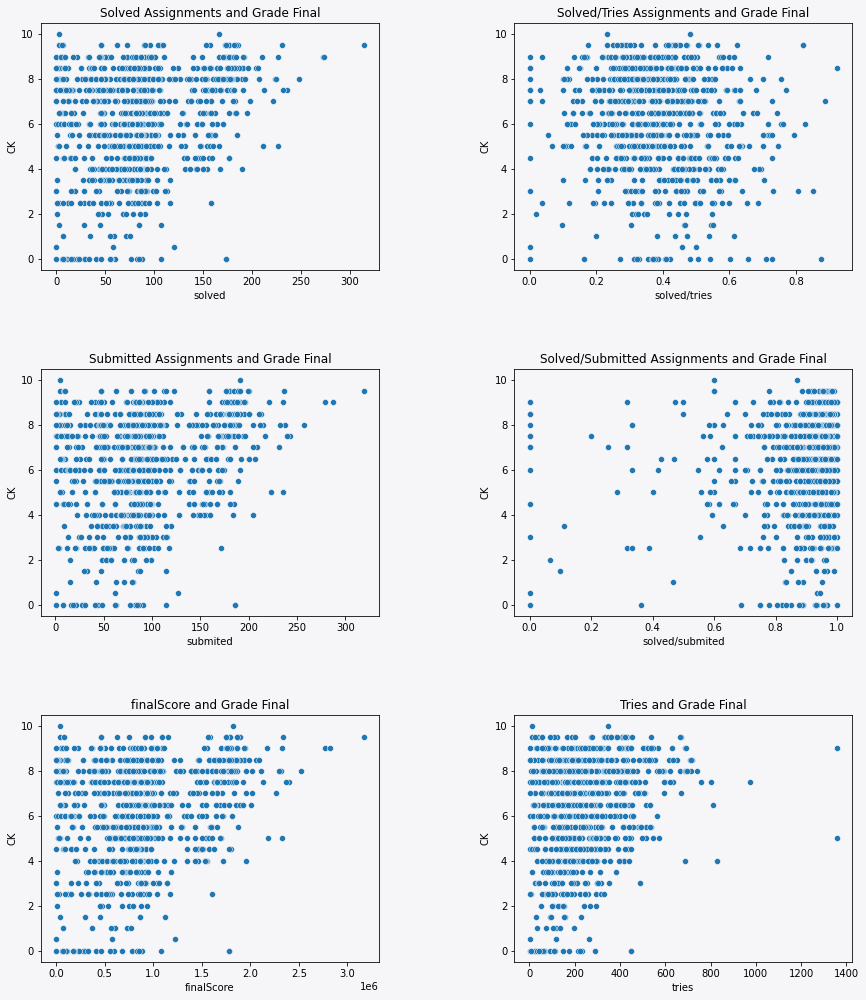

In [ ]:
fig= plt.figure(figsize = (40,30))
gs1 = fig.add_gridspec(3,3)
gs1.update(wspace=0.4, hspace=0.4)

axs0 = fig.add_subplot(gs[0,0])
axs1 = fig.add_subplot(gs[0,1])
axs2 = fig.add_subplot(gs[1,0])
axs3 = fig.add_subplot(gs[1,1])
axs4 = fig.add_subplot(gs[2,0])
axs5 = fig.add_subplot(gs[2,1])
axes=[axs0,axs1,axs2,axs3,axs4, axs5]
background_color = '#f6f5f7'

for i in axes:
    i.set_facecolor(background_color)
fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs0, x = data_to_train['solved'], y = data_to_train['CK'].sort_values() )
axs0.set_title('Solved Assignments and Grade Final')

fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs1, x = data_to_train['solved/tries'], y = data_to_train['CK'].sort_values())
axs1.set_title('Solved/Tries Assignments and Grade Final')

fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs2,x = data_to_train['submited'], y = data_to_train['CK'].sort_values())
axs2.set_title('Submitted Assignments and Grade Final')

fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs3,x = data_to_train['solved/submited'], y = data_to_train['CK'].sort_values())
axs3.set_title('Solved/Submitted Assignments and Grade Final')

fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs4,x = data_to_train['finalScore'], y = data_to_train['CK'].sort_values())
axs4.set_title('finalScore and Grade Final')

fig.patch.set_facecolor(background_color) 
sns.scatterplot(ax = axs5,x = data_to_train['tries'], y = data_to_train['CK'].sort_values())
axs5.set_title('Tries and Grade Final')

plt.show()

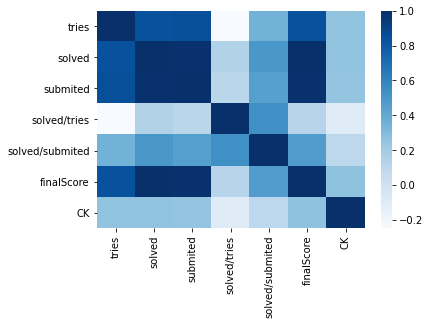

In [ ]:
cormat = data_to_train.corr()
sns.heatmap(cormat, cmap = 'Blues')

In [ ]:
data_to_train = data_to_train.drop(['tries','solved/tries', 'solved/submited'], axis = 1)
data_to_predict = data_to_predict.drop(['tries','solved/tries', 'solved/submited'], axis = 1)

In [ ]:
data_to_train.describe()

,solved,submited,finalScore,CK
count,920.000000,920.000000,9.200000e+02,920.000000
mean,86.750000,93.559783,8.952187e+05,6.192935
std,52.366214,53.692214,5.338194e+05,2.238136
min,0.000000,1.000000,0.000000e+00,0.000000
25%,50.750000,58.000000,5.288322e+05,5.000000
50%,83.000000,87.000000,8.479760e+05,6.500000
75%,105.250000,113.000000,1.086106e+06,8.000000
max,314.000000,319.000000,3.168763e+06,10.000000


In [ ]:
data_to_train.to_csv('/content/data_train.csv')
data_to_predict.to_csv('/content/data_test.csv')

In [ ]:
X = data_to_train.iloc[:,data_to_train.columns!='CK']
y = data_to_train.iloc[:,-1]
# X = np.array(data_to_train['finalScore']).reshape(-1,1)
# y = data_to_train['CK']
X

,solved,submited,finalScore
22,12.0,12.0,120000.0
24,72.0,78.0,750299.0
27,3.0,5.0,39000.0
28,3.0,5.0,39000.0
29,72.0,80.0,762760.0
...,...,...,...
1857,37.0,40.0,386000.0
1859,3.0,30.0,39000.0
1862,4.0,6.0,40000.0
1865,10.0,17.0,116428.0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
x_train

,solved,submited,finalScore
151,173.0,186.0,1782358.0
95,2.0,6.0,20000.0
540,74.0,83.0,783777.0
471,92.0,96.0,929000.0
1433,57.0,64.0,591467.0
...,...,...,...
1603,186.0,189.0,1876388.0
361,71.0,80.0,724804.0
1191,106.0,109.0,1069000.0
1017,58.0,72.0,646057.0


In [ ]:
def normalize_train_test(X_train, X_test, raw_X, mode="StandardScaler"):
  if mode == "StandardScaler":
    scaler = StandardScaler()
  elif mode == "MinMaxScaler":
    scaler = MinMaxScaler()
  elif mode == "RobustScaler":
    scaler = RobustScaler()

  scaler = scaler.fit(X_train)
  
  X_train_std = scaler.transform(X_train)
  X_test_std = scaler.transform(X_test)
  raw_X_std = scaler.transform(raw_X)

  return scaler, X_train_std, X_test_std

In [ ]:
scaler, X_train_std, X_test_std = normalize_train_test(x_train, x_test, X, mode="StandardScaler")

In [ ]:
poly = PolynomialFeatures(2)
x_train_poly = poly.fit_transform(X_train_std)
x_test_poly = poly.transform(X_test_std)
x_train_poly[0]

array([1.        , 1.61850921, 1.69276275, 1.63499452, 2.61957205,
       2.7397521 , 2.64625368, 2.86544574, 2.76765782, 2.67320708])

#3 Building Model to Predict and Testing
<a name = 'model'></a>

## Bulding Model

In [ ]:
def train_model(X_train, y_train, mode = "Ridge"):
  if mode == "LinearRegression":
    model = LinearRegression()
  elif mode == "Ridge":
    model = Ridge()
  elif mode == "Lasso":
    model = Lasso()

  model.fit(X_train, y_train)

  return model

def predict_model(model, X_test):
  y_logit = model.predict(X_test)

  return y_logit

In [ ]:
model  = LinearRegression().fit(x_train_poly, y_train)
prediction = predict_model(model, x_test_poly)
prediction = prediction*2.0
prediction = prediction.astype(int)
prediction = np.round_(prediction/2, decimals=1, out=None)
prediction

array([5. , 6.5, 6.5, 6. , 5. , 6.5, 5. , 7. , 4. , 5. , 5.5, 4.5, 7. ,
       5.5, 6.5, 7.5, 5. , 5. , 7. , 6.5, 5. , 5. , 6.5, 6.5, 5.5, 6. ,
       2.5, 6.5, 6. , 6.5, 6.5, 6.5, 5. , 6.5, 5. , 6.5, 6.5, 6. , 6. ,
       5.5, 6. , 6. , 5.5, 6.5, 5.5, 5.5, 5. , 6. , 6. , 5. , 4. , 7. ,
       6. , 6. , 6. , 6. , 6. , 3.5, 5.5, 4.5, 6.5, 5.5, 5. , 6.5, 7.5,
       5.5, 6.5, 5. , 5.5, 5.5, 6. , 4.5, 5.5, 5. , 7. , 5.5, 6. , 5.5,
       6.5, 5.5, 6. , 6.5, 4.5, 6. , 6. , 5. , 4. , 6.5, 6. , 7.5, 5. ,
       4.5, 5.5, 6.5, 6.5, 4.5, 6.5, 8.5, 6. , 5.5, 7.5, 7.5, 7. , 5.5,
       7.5, 5. , 5.5, 5.5, 5.5, 7. , 4.5, 5.5, 6. , 5. , 4.5, 7.5, 7. ,
       5.5, 5.5, 5.5, 6.5, 6. , 7.5, 6.5, 7.5, 6.5, 4. , 4.5, 6.5, 6.5,
       4.5, 7. , 5.5, 5.5, 7. , 7. , 6.5, 7.5, 5.5, 6. , 6.5, 6. , 6.5,
       5.5, 6.5, 6. , 6. , 5.5, 6.5, 7. , 6. , 6.5, 6.5, 6.5, 4. , 6. ,
       5. , 6.5, 4. , 7. , 6. , 5.5, 3.5, 6.5, 3.5, 6.5, 4.5, 6.5, 5.5,
       6.5, 7. , 5.5, 5.5, 5.5, 6. , 6.5, 7.5, 5.5, 5.5, 4. , 6.

In [ ]:
# print('Model score on x_test', lr_model.score(x_test, y_test))
print('MSE: ', mean_squared_error(_predition, y_test))

MSE:  4.746376811594203


In [ ]:
x_predict = data_to_predict.iloc[:,data_to_predict.columns!='CK']
# x_predict = x_predict.drop(['tries','solved/tries', 'solved/submited'], axis = 1)
x_std = scaler.transform(x_predict)
x_predict_poly = poly.fit_transform(x_std)

In [ ]:
#submit prediction
y_predict = lr_model.predict(x_predict_poly)
y_predict = y_predict*2.0
y_predict = y_predict.astype(int)
y_predict = np.round(y_predict/2, decimals=1, out=None)
y_predict
result = {
    "id": id_predict,
    "CK" :y_predict
}
result_submit = pd.DataFrame(result)
result_submit

,id,CK
0,1,5.0
1,4,4.5
2,5,5.0
3,6,5.0
4,7,5.5
...,...,...
355,1852,5.5
356,1855,6.0
357,1860,5.0
358,1864,7.5
